# ViT Small Model - Plant Disease Prediction

In [6]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import timm
from pathlib import Path

# Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = 'mlflow_vitsmall/mlflow_vit/423964100717433275/3ec8c39304544c90b286b93f5ee79e62/artifacts/state_dict_vit.pt'
IMAGE_DIR = 'vit_data/33try'

# Full PlantVillage class names (38 classes)
class_names = [
    'Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy',
    'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_',
    'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy',
    'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy',
    'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy',
    'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy',
    'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy',
    'Raspberry___healthy', 'Soybean___healthy',
    'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy',
    'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight',
    'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot',
    'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy'
]

print(f"Device: {device}")
print(f"Classes: {len(class_names)}")

Device: cpu
Classes: 38


In [8]:
# Load MLflow saved model (38 classes) - vit_tiny architecture
checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)
model = timm.create_model('vit_tiny_patch16_224', pretrained=False, drop_rate=0.2)
model.head = nn.Sequential(nn.Dropout(0.2), nn.Linear(model.head.in_features, len(class_names)))
model.load_state_dict(checkpoint)
model = model.to(device).eval()
print("✅ Model loaded!")

✅ Model loaded!


In [9]:
# Get all image files
image_dir = Path(IMAGE_DIR)
image_files = sorted([f for f in image_dir.glob('*') if f.suffix.upper() in ['.JPG', '.JPEG', '.PNG']])
print(f"✅ Found {len(image_files)} images")

✅ Found 33 images


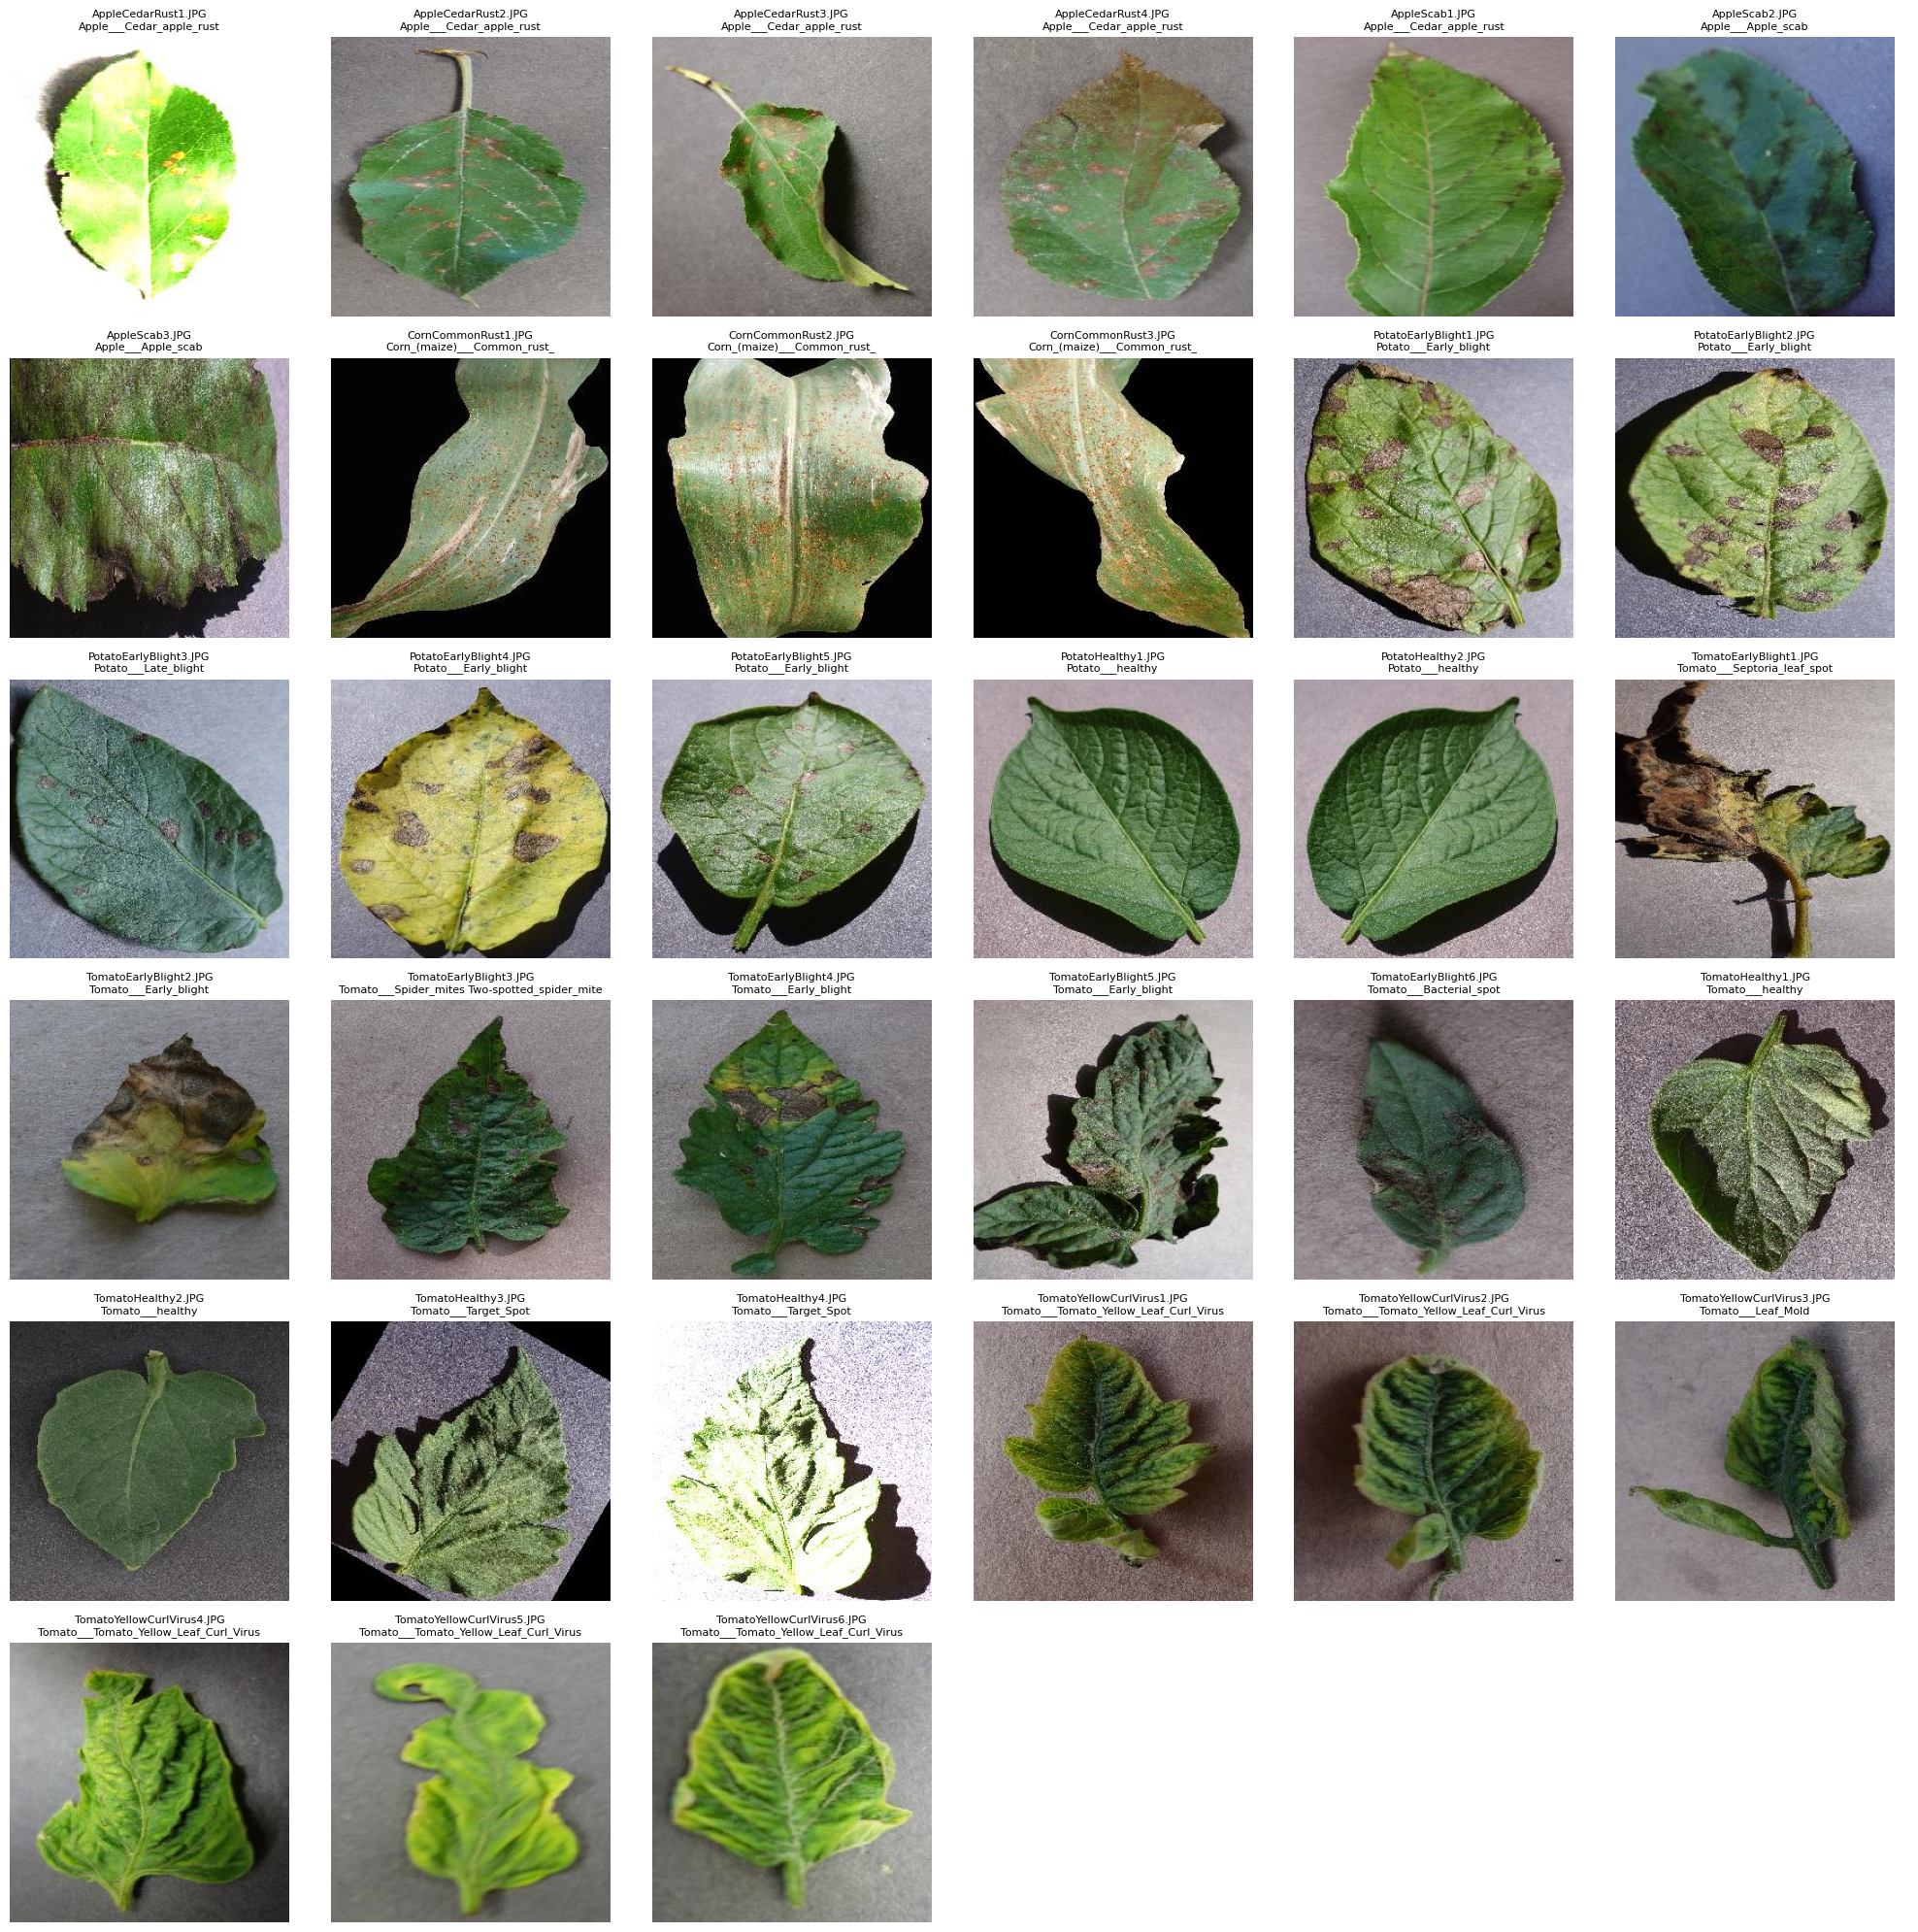

In [10]:
# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Predict and display - 6x6 grid for 33 images
cols = 6
rows = 6
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
axes = axes.flatten()

results = []
for i, img_path in enumerate(image_files):
    img = Image.open(img_path).convert('RGB')
    
    with torch.no_grad():
        output = model(transform(img).unsqueeze(0).to(device))
        pred_idx = output.argmax(1).item()
        pred_name = class_names[pred_idx]
    
    results.append({'Filename': img_path.name, 'Predicted': pred_name})
    
    axes[i].imshow(img)
    axes[i].set_title(f"{img_path.name}\n{pred_name}", fontsize=8)
    axes[i].axis('off')

# Hide unused axes
for j in range(len(image_files), rows * cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [11]:
import pandas as pd
df = pd.DataFrame(results)
print(df.to_string(index=False))

                  Filename                                     Predicted
       AppleCedarRust1.JPG                      Apple___Cedar_apple_rust
       AppleCedarRust2.JPG                      Apple___Cedar_apple_rust
       AppleCedarRust3.JPG                      Apple___Cedar_apple_rust
       AppleCedarRust4.JPG                      Apple___Cedar_apple_rust
            AppleScab1.JPG                      Apple___Cedar_apple_rust
            AppleScab2.JPG                            Apple___Apple_scab
            AppleScab3.JPG                            Apple___Apple_scab
       CornCommonRust1.JPG                   Corn_(maize)___Common_rust_
       CornCommonRust2.JPG                   Corn_(maize)___Common_rust_
       CornCommonRust3.JPG                   Corn_(maize)___Common_rust_
    PotatoEarlyBlight1.JPG                         Potato___Early_blight
    PotatoEarlyBlight2.JPG                         Potato___Early_blight
    PotatoEarlyBlight3.JPG                         

In [ ]:
print("vit_tiny_patch16_224​ model predictions done!:)")